### P2 - Weather Data (APIs) - Part 2(Weather Alert)

GROUP #14 DETAILS<br>
<br>
 1	Amita Singh                 219485309	amita15@schulich.yorku.ca<br>
 2	Saima Rafi	                216562753	saima20@schulich.yorku.ca<br>
 3	Sreekanth Potlabathini 	    220088993	sriku241@schulich.yorku.ca<br>
 4	Abdul Ghafar Qasemi	        220067401	agqasemi@schulich.yorku.ca<br>  

--------------------------------------------------------------------------------------------------------------

For this project you will work on three data pipelines<br>
<br>
A common problem in Logistics is the optimization of delivery routes using distance and weather data. For this assignment you will need to identify an API that can provide:<br>
<br>
Historical Weather data<br>
Current Weather<br>
Weather Forecasts<br>
### Weather Alerts (you will need to work with the data available here: https://dd.weather.gc.ca/Links to an external site.)<br> file contains only the last portion
Most APIs from big providers provide (limited) free requests that should allow you to pull a sample dataset without having to pay for a subscription<br>
<br>
Create an uploads schema in your own database within our Postgres server (do not use the mban_db database)<br>
Prepare a data ingestion pipeline for each data source. The data ingestion pipeline must be designed to be scheduled (i.e. it should take the current date as an input so it can run every day and update your tables)<br>
Each data ingestion pipeline must include data cleaning and feature engineering<br>
Create new tables in the uploads schema to capture the weather data.<br>

--------------------------------------------------------------------------------------------------------------

In [1]:
import requests
import re
import os
import math
import pandas as pd
import xml.etree.ElementTree as et
import seaborn as sns
import matplotlib.pyplot as plt
import sqlalchemy as sa
from datetime import datetime, timedelta
from sqlalchemy import text
from shapely.geometry import Point, Polygon
from scipy.spatial import ConvexHull


In [2]:
cities = pd.read_csv(r'C:\Users\srika\OneDrive\Documents\York\Sem-1 york\MMAI 5100 - database fundamentals\ca_geo_dimension.csv',usecols=['province', 'region', 'latitude', 'longitude'])
cities.drop_duplicates(inplace=True)
cities.sample(10)

,province,region,latitude,longitude
619907,Ontario,Algoma,46.521116,-84.349870
487685,Ontario,Durham,44.104703,-79.111450
468426,Ontario,Halton,43.351868,-79.768245
451463,Ontario,Halton,43.442130,-79.674843
423648,Ontario,York,43.994937,-79.472118
638092,Manitoba,Winnipeg,49.805813,-97.087726
663860,Saskatchewan,Regina,50.408836,-104.628179
324824,Quebec,Outaouais,45.453081,-75.744588
94885,New Brunswick,Madawaska,47.252900,-68.603032
376310,Ontario,Peterborough,44.311740,-78.317326


In [3]:
current_date = datetime.now().strftime('%Y%m%d')
now = datetime.now()
hours = [(now - timedelta(hours=i)).strftime('%H') for i in range(8)]

In [4]:
base_url = "https://dd.weather.gc.ca/alerts/cap/"
responsible_offices = ['CWUL', 'CWEG', 'CWNT', 'CWWG', 'CWVR', 'CWTO', 'CYQX', 'CWAO', 'CWIS', 'CWHX', 'LAND']
namespaces = {'cap': 'urn:oasis:names:tc:emergency:cap:1.2'}

In [5]:
urls_cap = []

In [6]:
for office in responsible_offices:
    for hour in hours:
        url = f"{base_url}{current_date}/{office}/{hour}/"
        try:
            response = requests.get(url, timeout=10)
            if response.status_code == 200:
                filenames = re.findall(r'href="(.*\.cap)"', response.text)
                for filename in filenames:
                    cap_url = url + filename
                    urls_cap.append(cap_url)
                    print(f"Added {cap_url} to the list.")
        except requests.Timeout:
            print(f"Request to {url} timed out.")
        except requests.RequestException as e:
            print(f"Request to {url} failed: {e}")


Added https://dd.weather.gc.ca/alerts/cap/20230813/CWUL/15/T_WOCN21_C_CWUL_202308131522_1159717956.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWUL/15/T_WWCN10_C_CWUL_202308131522_3056434071.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWNT/17/T_WOCN21_C_CWNT_202308131711_4160002530.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWNT/17/T_WOCN24_C_CWNT_202308131711_2596599702.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWNT/10/T_WOCN21_C_CWNT_202308131016_3266453449.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWWG/14/T_WOCN11_C_CWWG_202308131442_2766183929.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWWG/14/T_WOCN13_C_CWWG_202308131442_1836760866.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWWG/10/T_WOCN13_C_CWWG_202308131026_3309201080.cap to the list.
Added https://dd.weather.gc.ca/alerts/cap/20230813/CWVR/12/T_WOCN21_C_CW

In [7]:
df = []

for url in urls_cap:
    response = requests.get(url)
    if response.status_code == 200:
        xml_content = response.content
        root = et.fromstring(xml_content)  
        event = root.find('.//cap:event', namespaces).text
        data = []
        for area in root.findall('.//cap:area', namespaces):
            poly_cor = area.find('.//cap:polygon', namespaces).text
            coords = poly_cor.split()
            for coord_pair in coords:
                lat, lon = map(float, coord_pair.split(','))
                data.append({'event': event, 'latitude': lat, 'longitude': lon})
        p_df = pd.DataFrame(data)
        df.append(p_df)  

final_df = pd.concat(df, ignore_index=True)

In [8]:
final_df['identifer']='alert'

In [9]:
final_df.head(30)

,event,latitude,longitude,identifer
0,qualité de l'air,51.6249,-76.0000,alert
1,qualité de l'air,50.5156,-75.9995,alert
2,qualité de l'air,50.5155,-79.5167,alert
3,qualité de l'air,50.7219,-79.5166,alert
4,qualité de l'air,51.0871,-79.5368,alert
5,qualité de l'air,51.4684,-79.5164,alert
6,qualité de l'air,51.5496,-79.5979,alert
7,qualité de l'air,51.7137,-79.4165,alert
8,qualité de l'air,51.7106,-79.1920,alert
9,qualité de l'air,51.6578,-79.1401,alert


<Axes: xlabel='latitude', ylabel='longitude'>

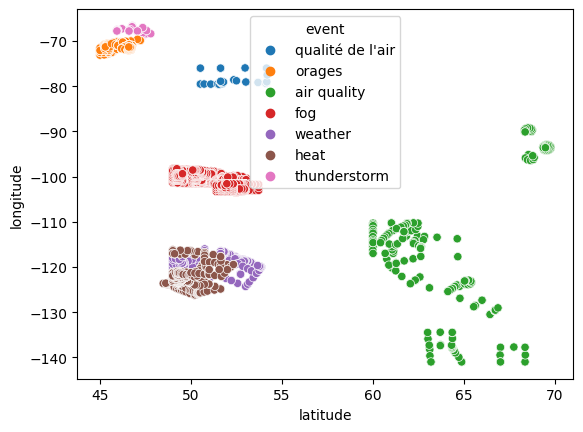

In [10]:

sns.scatterplot(data=final_df,x='latitude',y='longitude',hue = 'event')

In [11]:
cities['identifer']='city'
cities['event']='city'

In [12]:
cities.sample(20)

,province,region,latitude,longitude,identifer,event
369666,Ontario,Renfrew,45.473715,-76.678134,city,city
875551,British Columbia,Capital,48.449974,-123.296580,city,city
425787,Ontario,York,43.813998,-79.447005,city,city
261388,Quebec,Montérégie,45.296172,-73.260601,city,city
766910,Alberta,Grande Prairie,55.138532,-118.819320,city,city
252625,Quebec,Estrie,45.417660,-72.725562,city,city
773473,British Columbia,Fraser-Fort George,54.021253,-121.678595,city,city
469526,Ontario,Halton,43.338734,-79.842652,city,city
665046,Saskatchewan,Regina,50.459824,-104.619621,city,city
90783,New Brunswick,Kings,45.700553,-65.598740,city,city


In [13]:
# Keep only desired columns
dt = cities[['latitude', 'longitude', 'identifer','event']]
dp = final_df[['latitude', 'longitude', 'identifer','event']]

dg = pd.concat((dt, dp), axis=0)

In [14]:
dg

,latitude,longitude,identifer,event
0,47.582052,-53.279852,city,city
1,47.423351,-53.196602,city,city
2,47.385590,-53.134060,city,city
3,46.737209,-53.363831,city,city
4,47.536968,-53.269871,city,city
...,...,...,...,...
7311,46.726600,-71.443700,alert,orages
7312,46.699800,-71.433000,alert,orages
7313,46.678200,-71.411300,alert,orages
7314,46.654500,-71.387600,alert,orages


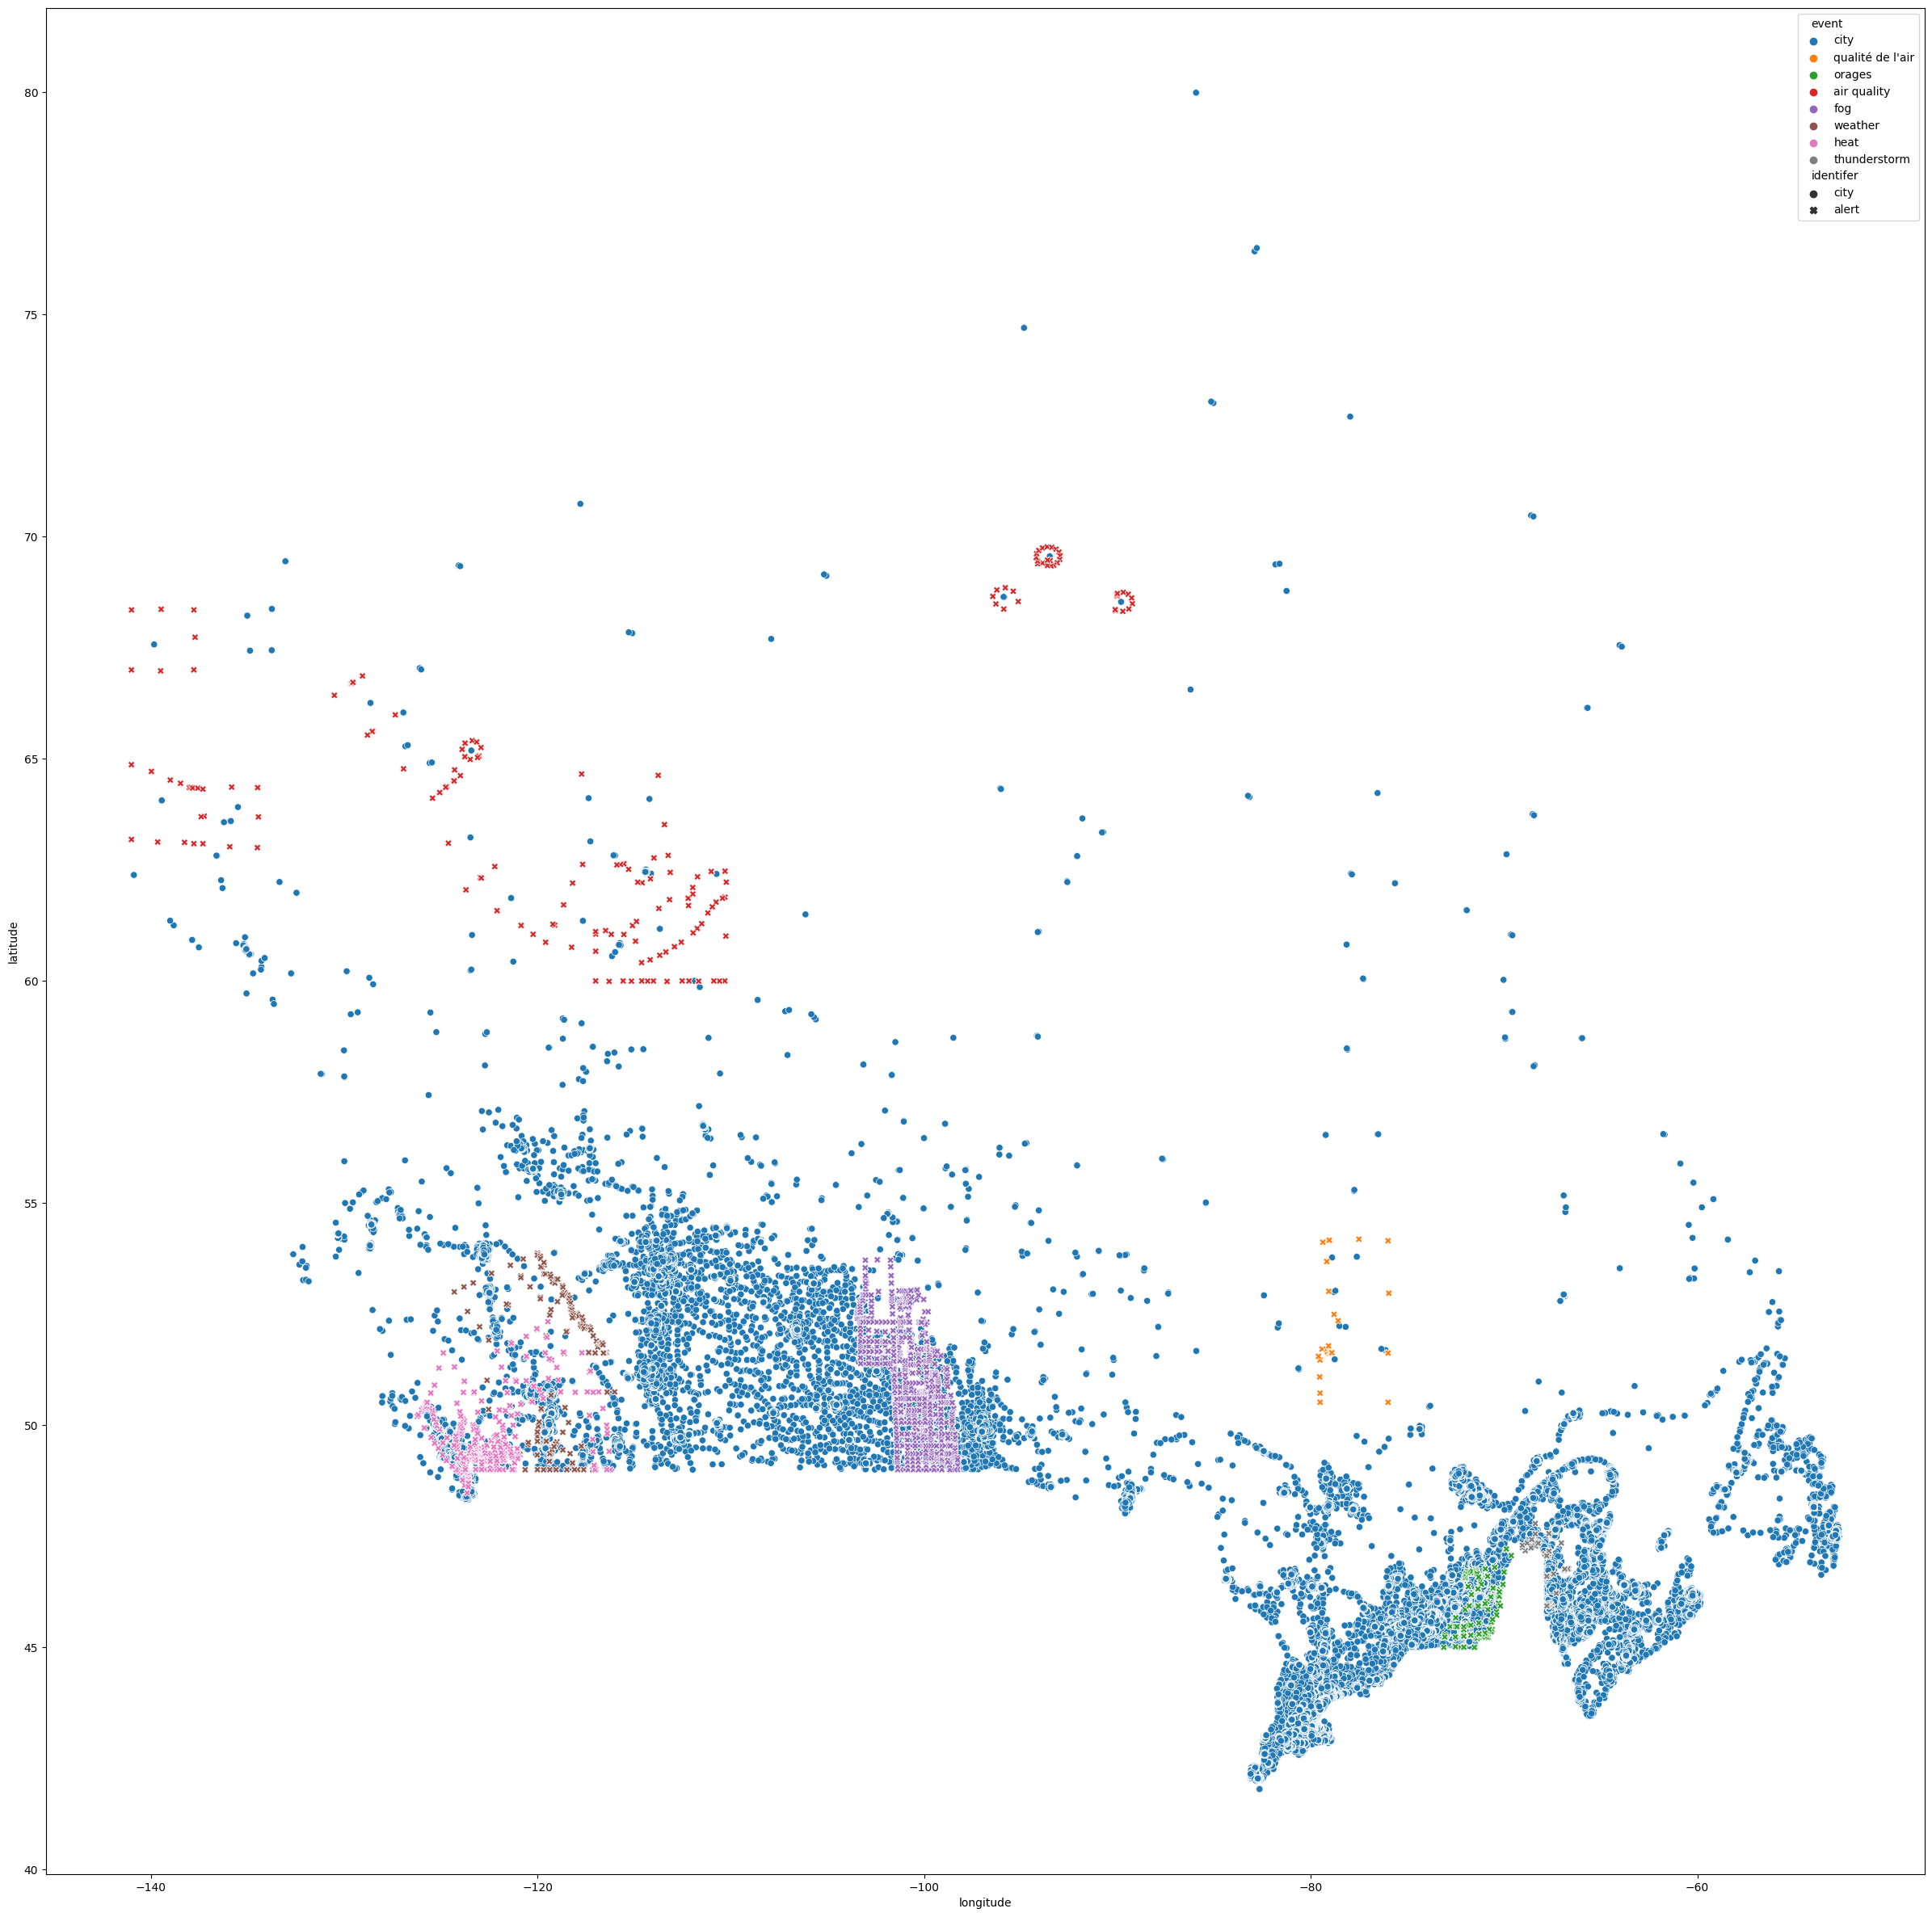

In [15]:

plt.figure(figsize=(30, 30))
sns.scatterplot ( data = dg, x='longitude',y='latitude',style='identifer',hue='event')
plt.show()

In [16]:
final_df.duplicated().count()

7316

In [17]:
final_df.drop_duplicates()

,event,latitude,longitude,identifer
0,qualité de l'air,51.6249,-76.0000,alert
1,qualité de l'air,50.5156,-75.9995,alert
2,qualité de l'air,50.5155,-79.5167,alert
3,qualité de l'air,50.7219,-79.5166,alert
4,qualité de l'air,51.0871,-79.5368,alert
...,...,...,...,...
7125,orages,46.7491,-71.4527,alert
7126,orages,46.7266,-71.4437,alert
7127,orages,46.6998,-71.4330,alert
7128,orages,46.6782,-71.4113,alert


In [18]:
final_df.head(30)

,event,latitude,longitude,identifer
0,qualité de l'air,51.6249,-76.0000,alert
1,qualité de l'air,50.5156,-75.9995,alert
2,qualité de l'air,50.5155,-79.5167,alert
3,qualité de l'air,50.7219,-79.5166,alert
4,qualité de l'air,51.0871,-79.5368,alert
5,qualité de l'air,51.4684,-79.5164,alert
6,qualité de l'air,51.5496,-79.5979,alert
7,qualité de l'air,51.7137,-79.4165,alert
8,qualité de l'air,51.7106,-79.1920,alert
9,qualité de l'air,51.6578,-79.1401,alert


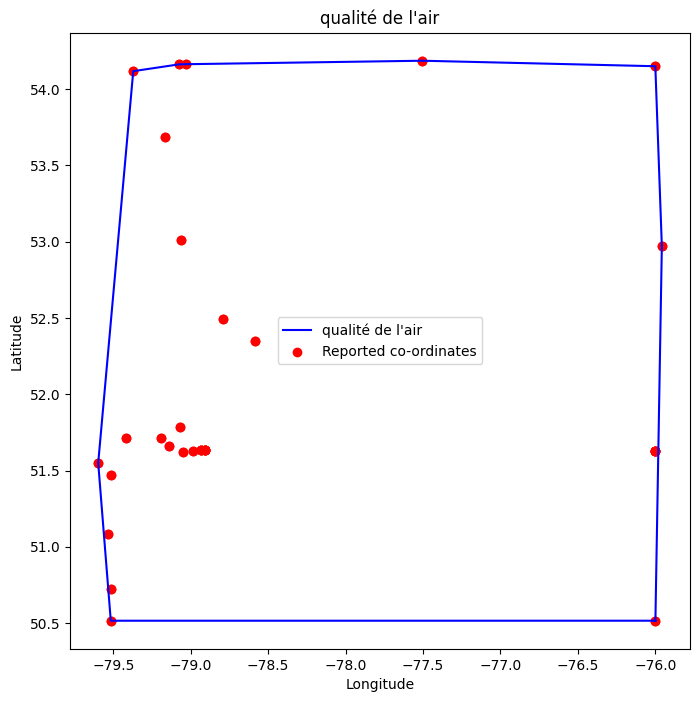

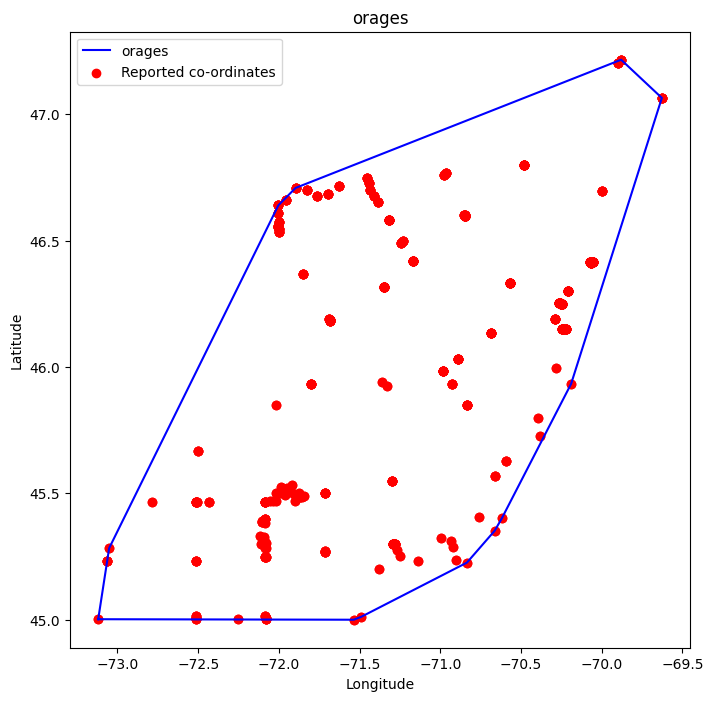

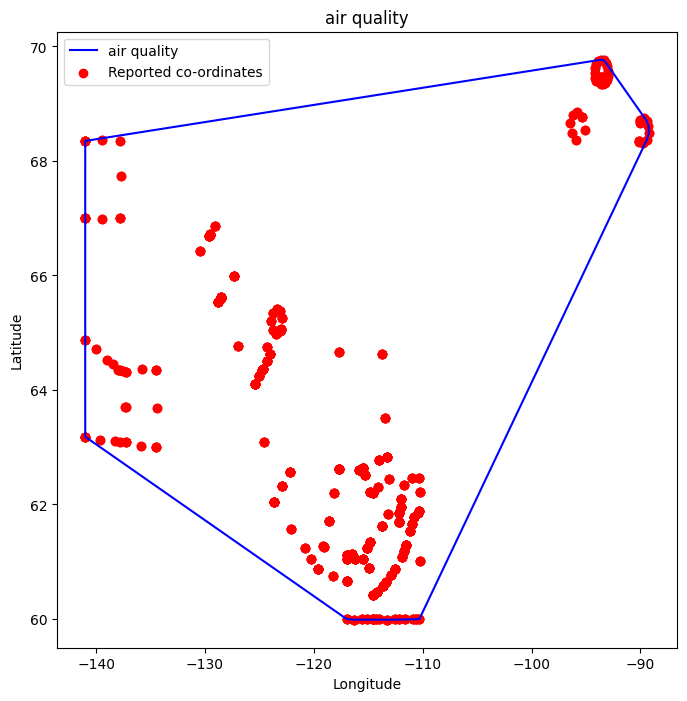

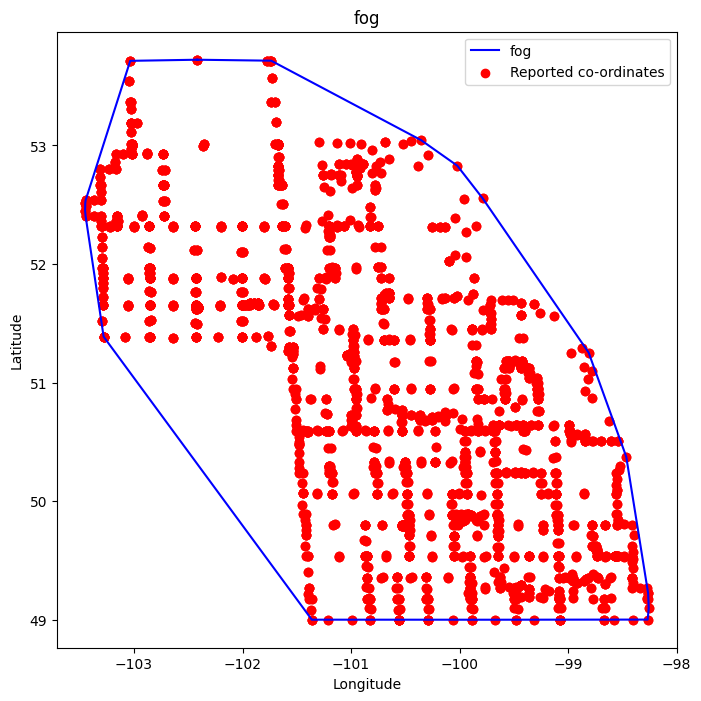

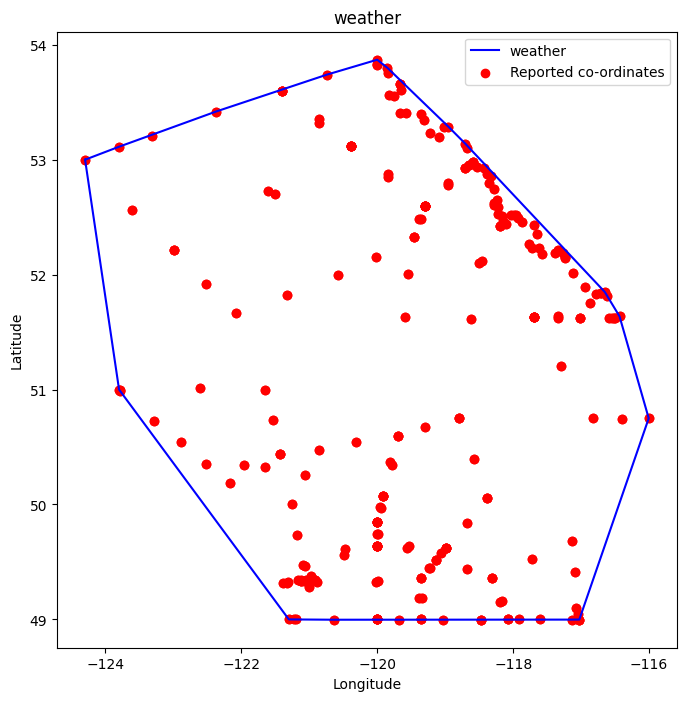

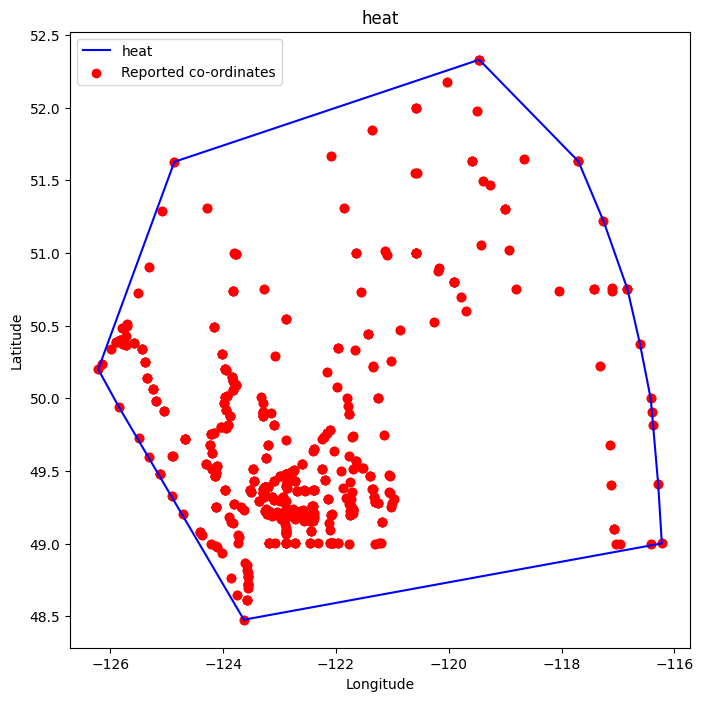

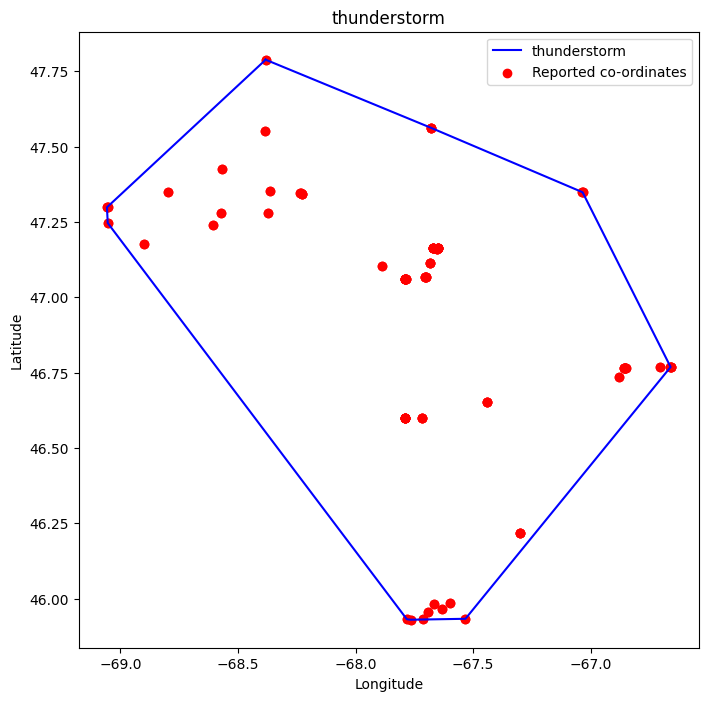

In [19]:
unique_events = final_df['event'].unique()

for event in unique_events:
    plt.figure(figsize=(8, 8))
    plt.title(event)
    event_data = final_df[final_df['event'] == event]
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    hull = ConvexHull(coords)
    hull_v = hull.vertices.tolist()
    hull_co = [coords[i] for i in hull_v]
    polygon = Polygon(hull_co)
    plt.plot(*polygon.exterior.xy, label=event, color='blue')
    plt.scatter(event_data['longitude'], event_data['latitude'], color='red', label='Reported co-ordinates') 
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.legend()
    plt.show()


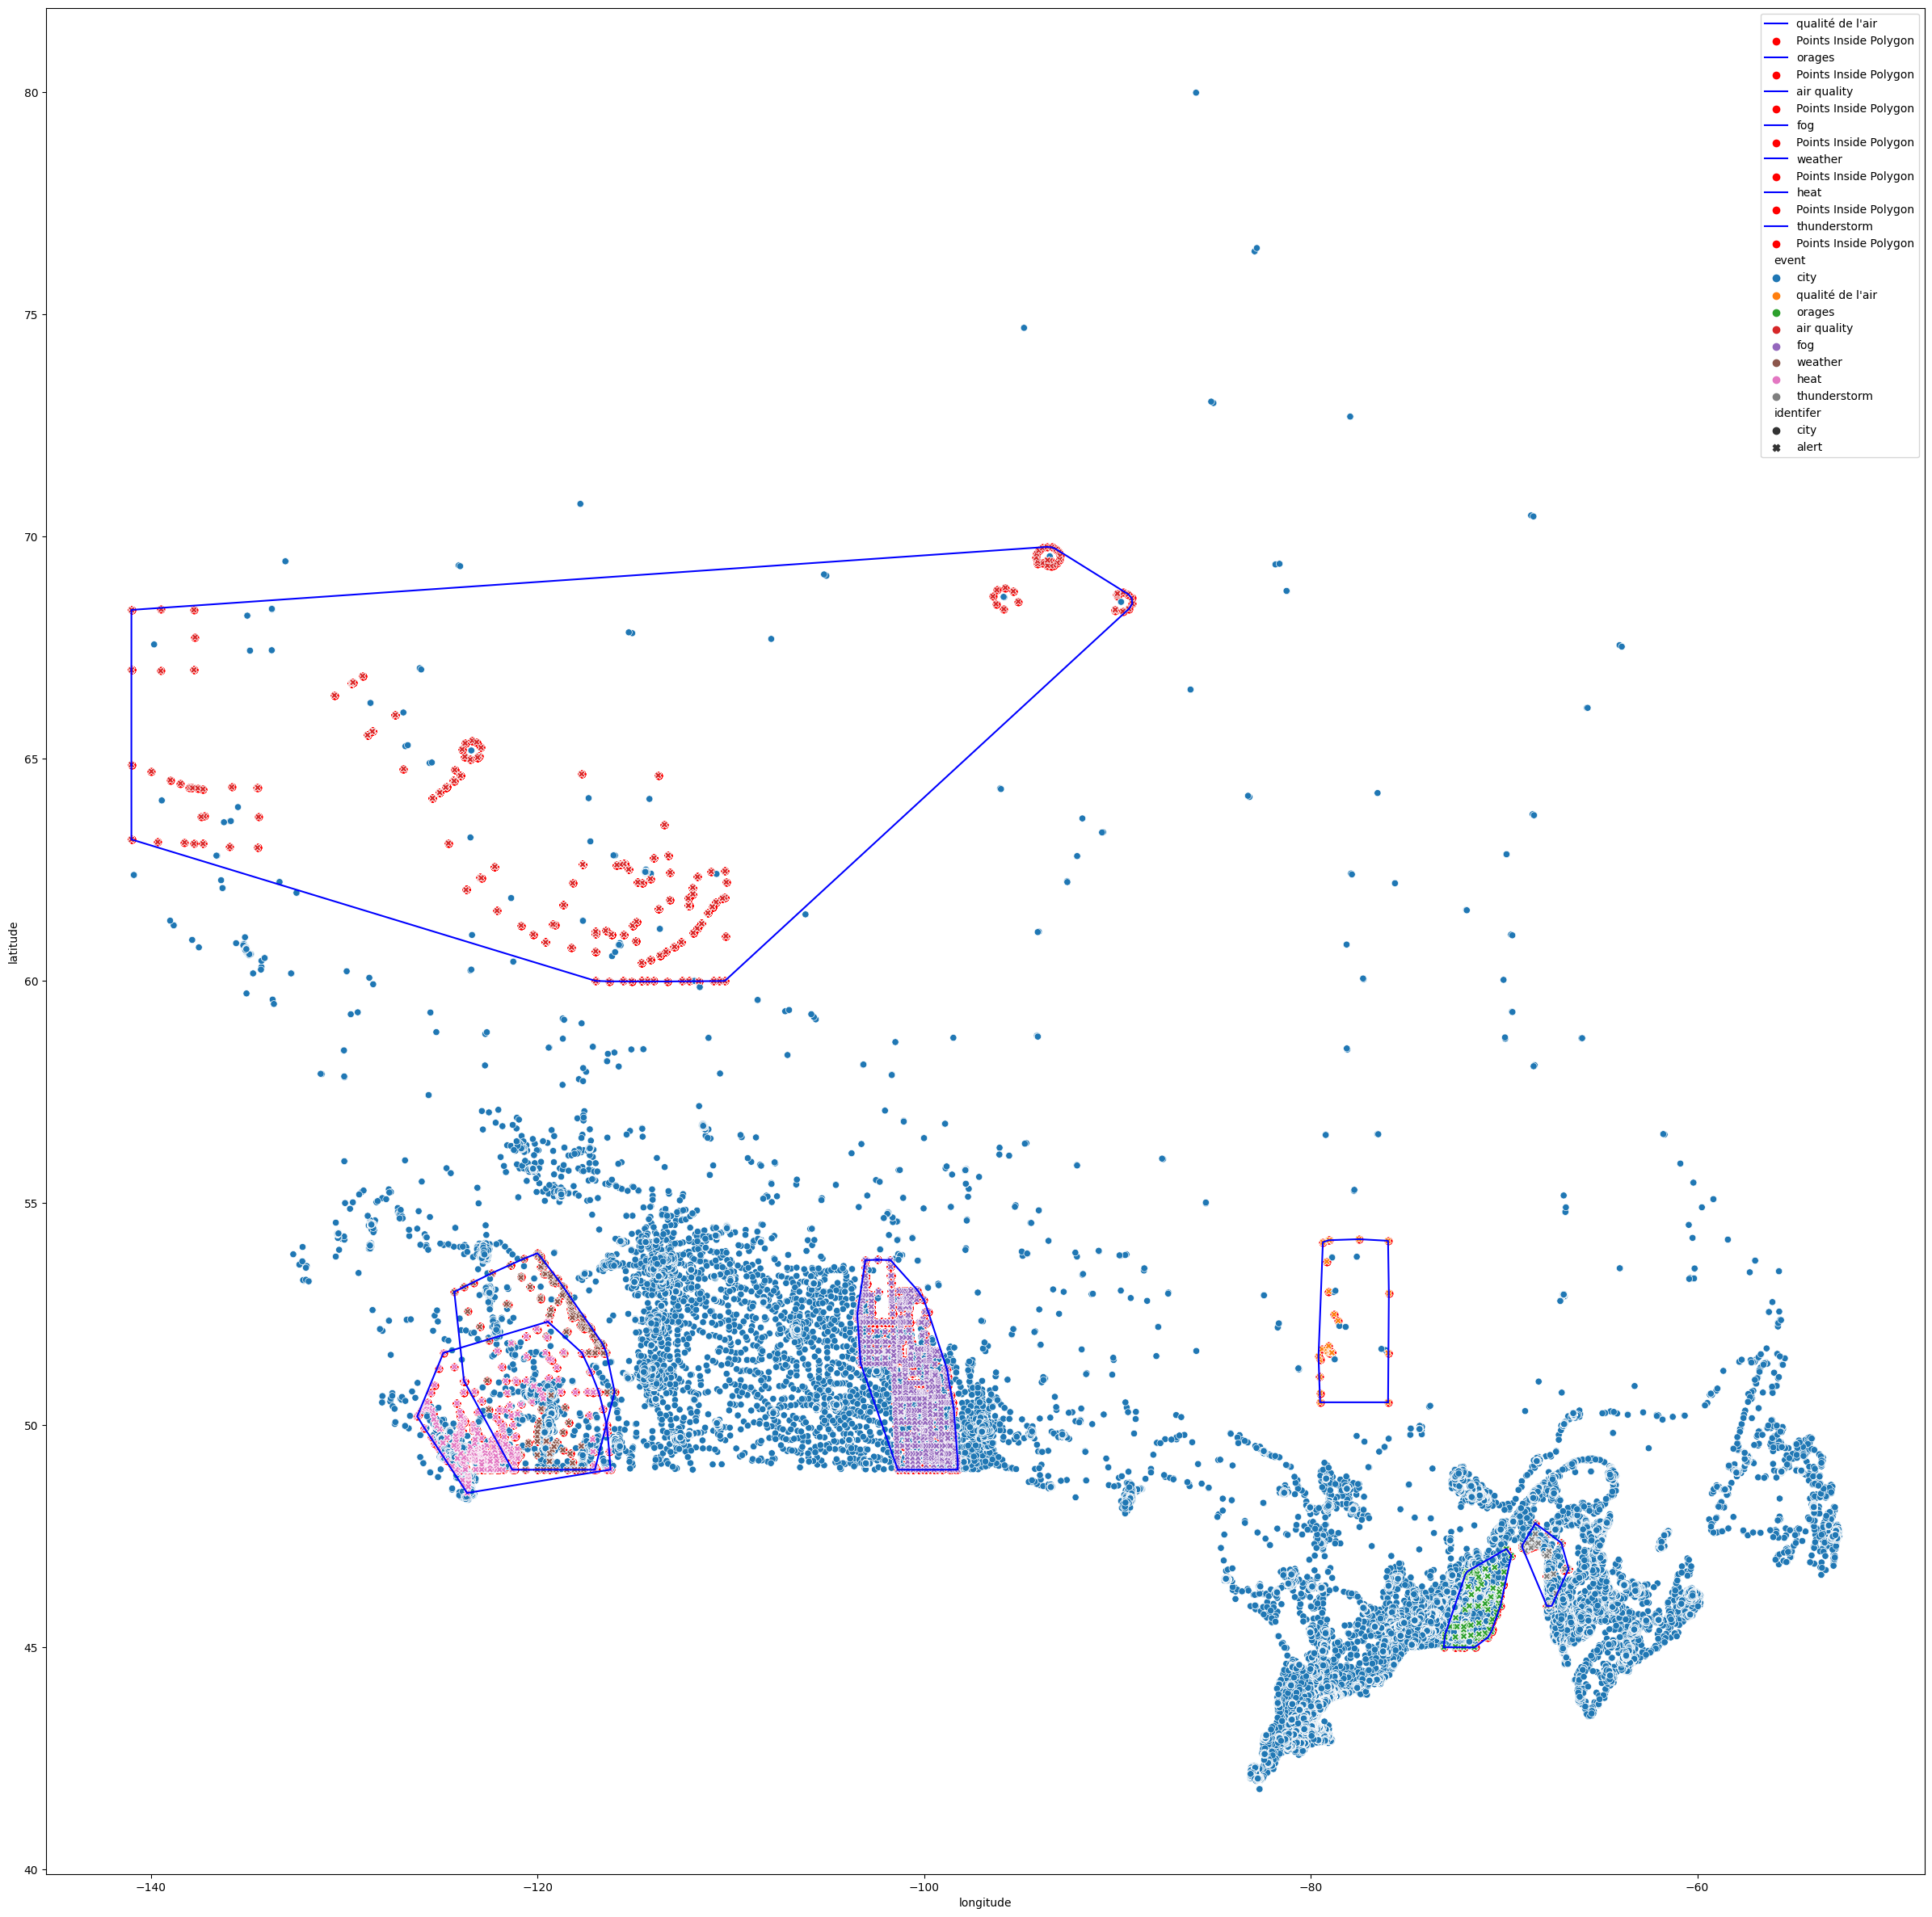

In [20]:
unique_events = final_df['event'].unique()

plt.figure(figsize=(30, 30))
for event in unique_events:
    event_data = final_df[final_df['event'] == event]    
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    hull = ConvexHull(coords)
    hull_v = hull.vertices.tolist()
    hull_co = [coords[i] for i in hull_v]
    polygon = Polygon(hull_co)
    plt.plot(*polygon.exterior.xy, label=event, color='blue')
    plt.scatter(event_data['longitude'], event_data['latitude'], color='red', label='Points Inside Polygon')


sns.scatterplot ( data = dg, x='longitude',y='latitude',style='identifer',hue='event')
plt.show()


As we go north the longitudes are very close. it makes sense if we can incluse some of the areas even though they look far in the scatter plot.

In [21]:
unique_events = final_df['event'].unique()
event_df = []
for event in unique_events:
    event_data = final_df[final_df['event'] == event]
    coords = list(zip(event_data['longitude'], event_data['latitude']))
    hull = ConvexHull(coords)
    hull_v = hull.vertices.tolist()
    hull_co = [coords[i] for i in hull_v]
    polygon = Polygon(hull_co)
    city_in_poly = cities[cities.apply(lambda row: polygon.contains(Point(row['longitude'], row['latitude'])), axis=1)]    
    city_in_poly['event'] = event
    event_df.append(city_in_poly)
city_event = pd.concat(event_df, ignore_index=True)

city_event.shape

C:\Users\srika\AppData\Local\Temp\ipykernel_13232\3867000692.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  city_in_poly['event'] = event


(174950, 6)

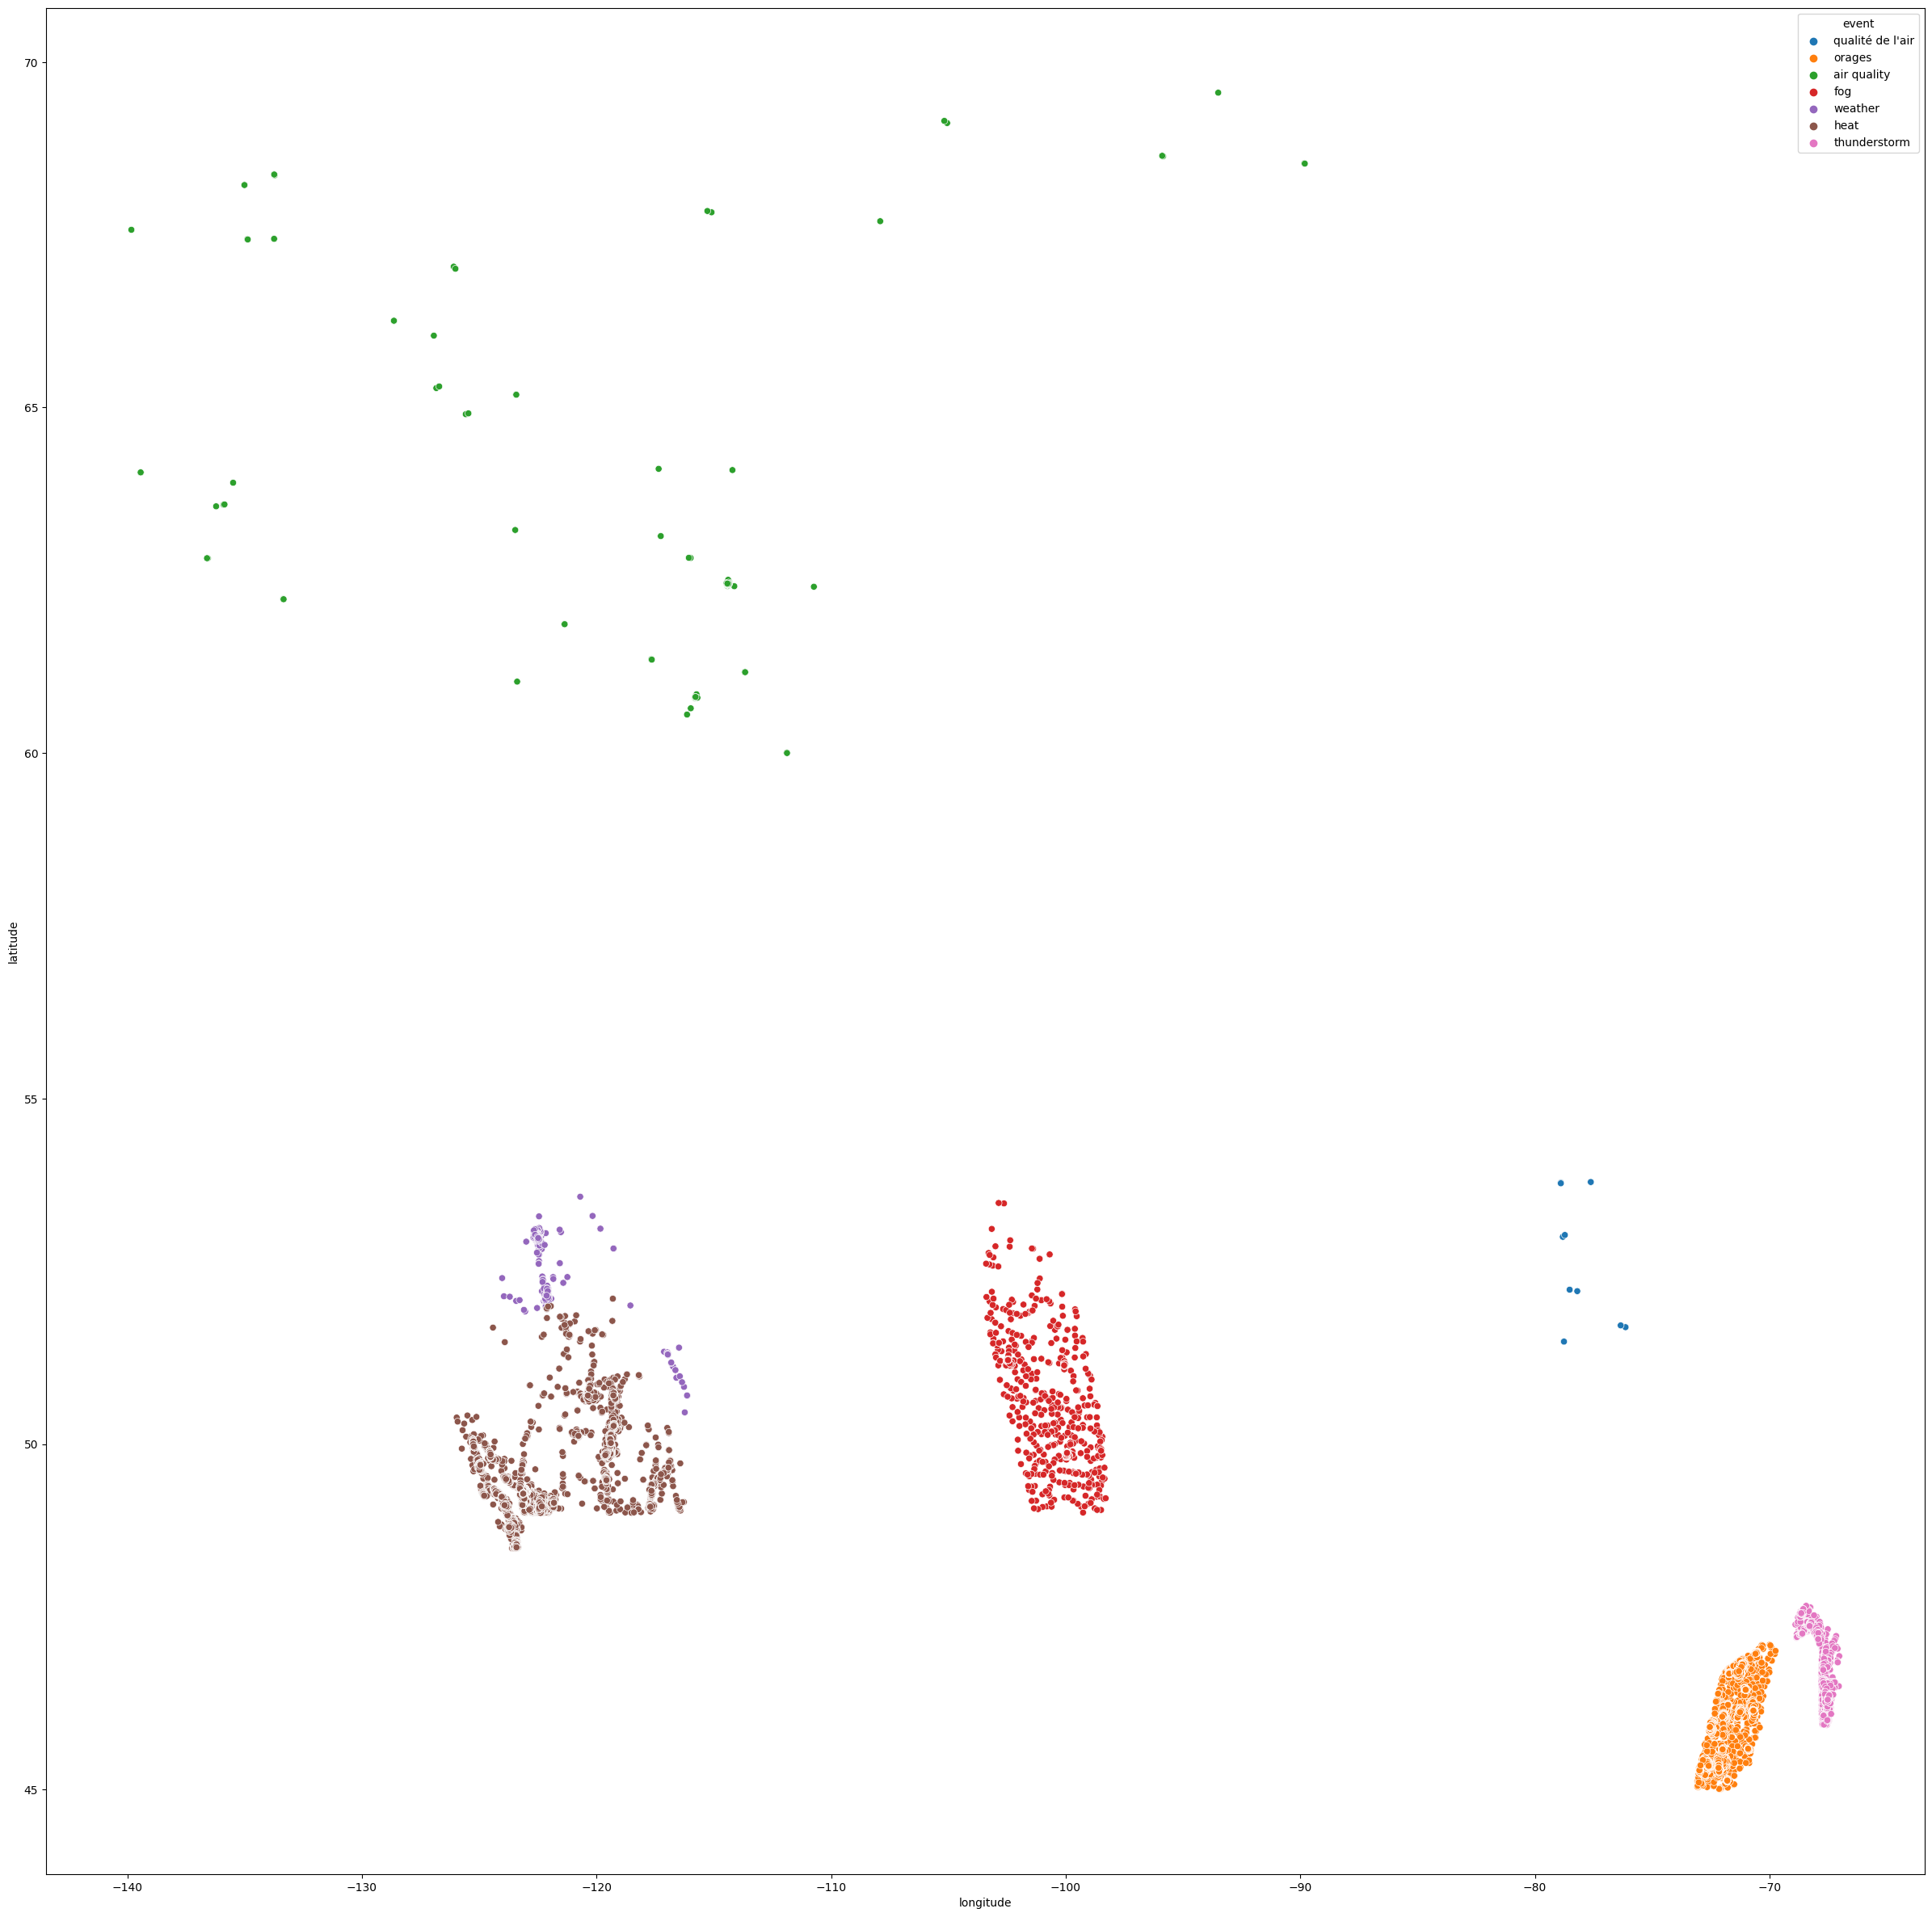

In [22]:
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = city_event, x='longitude',y='latitude',hue='event')
plt.show()

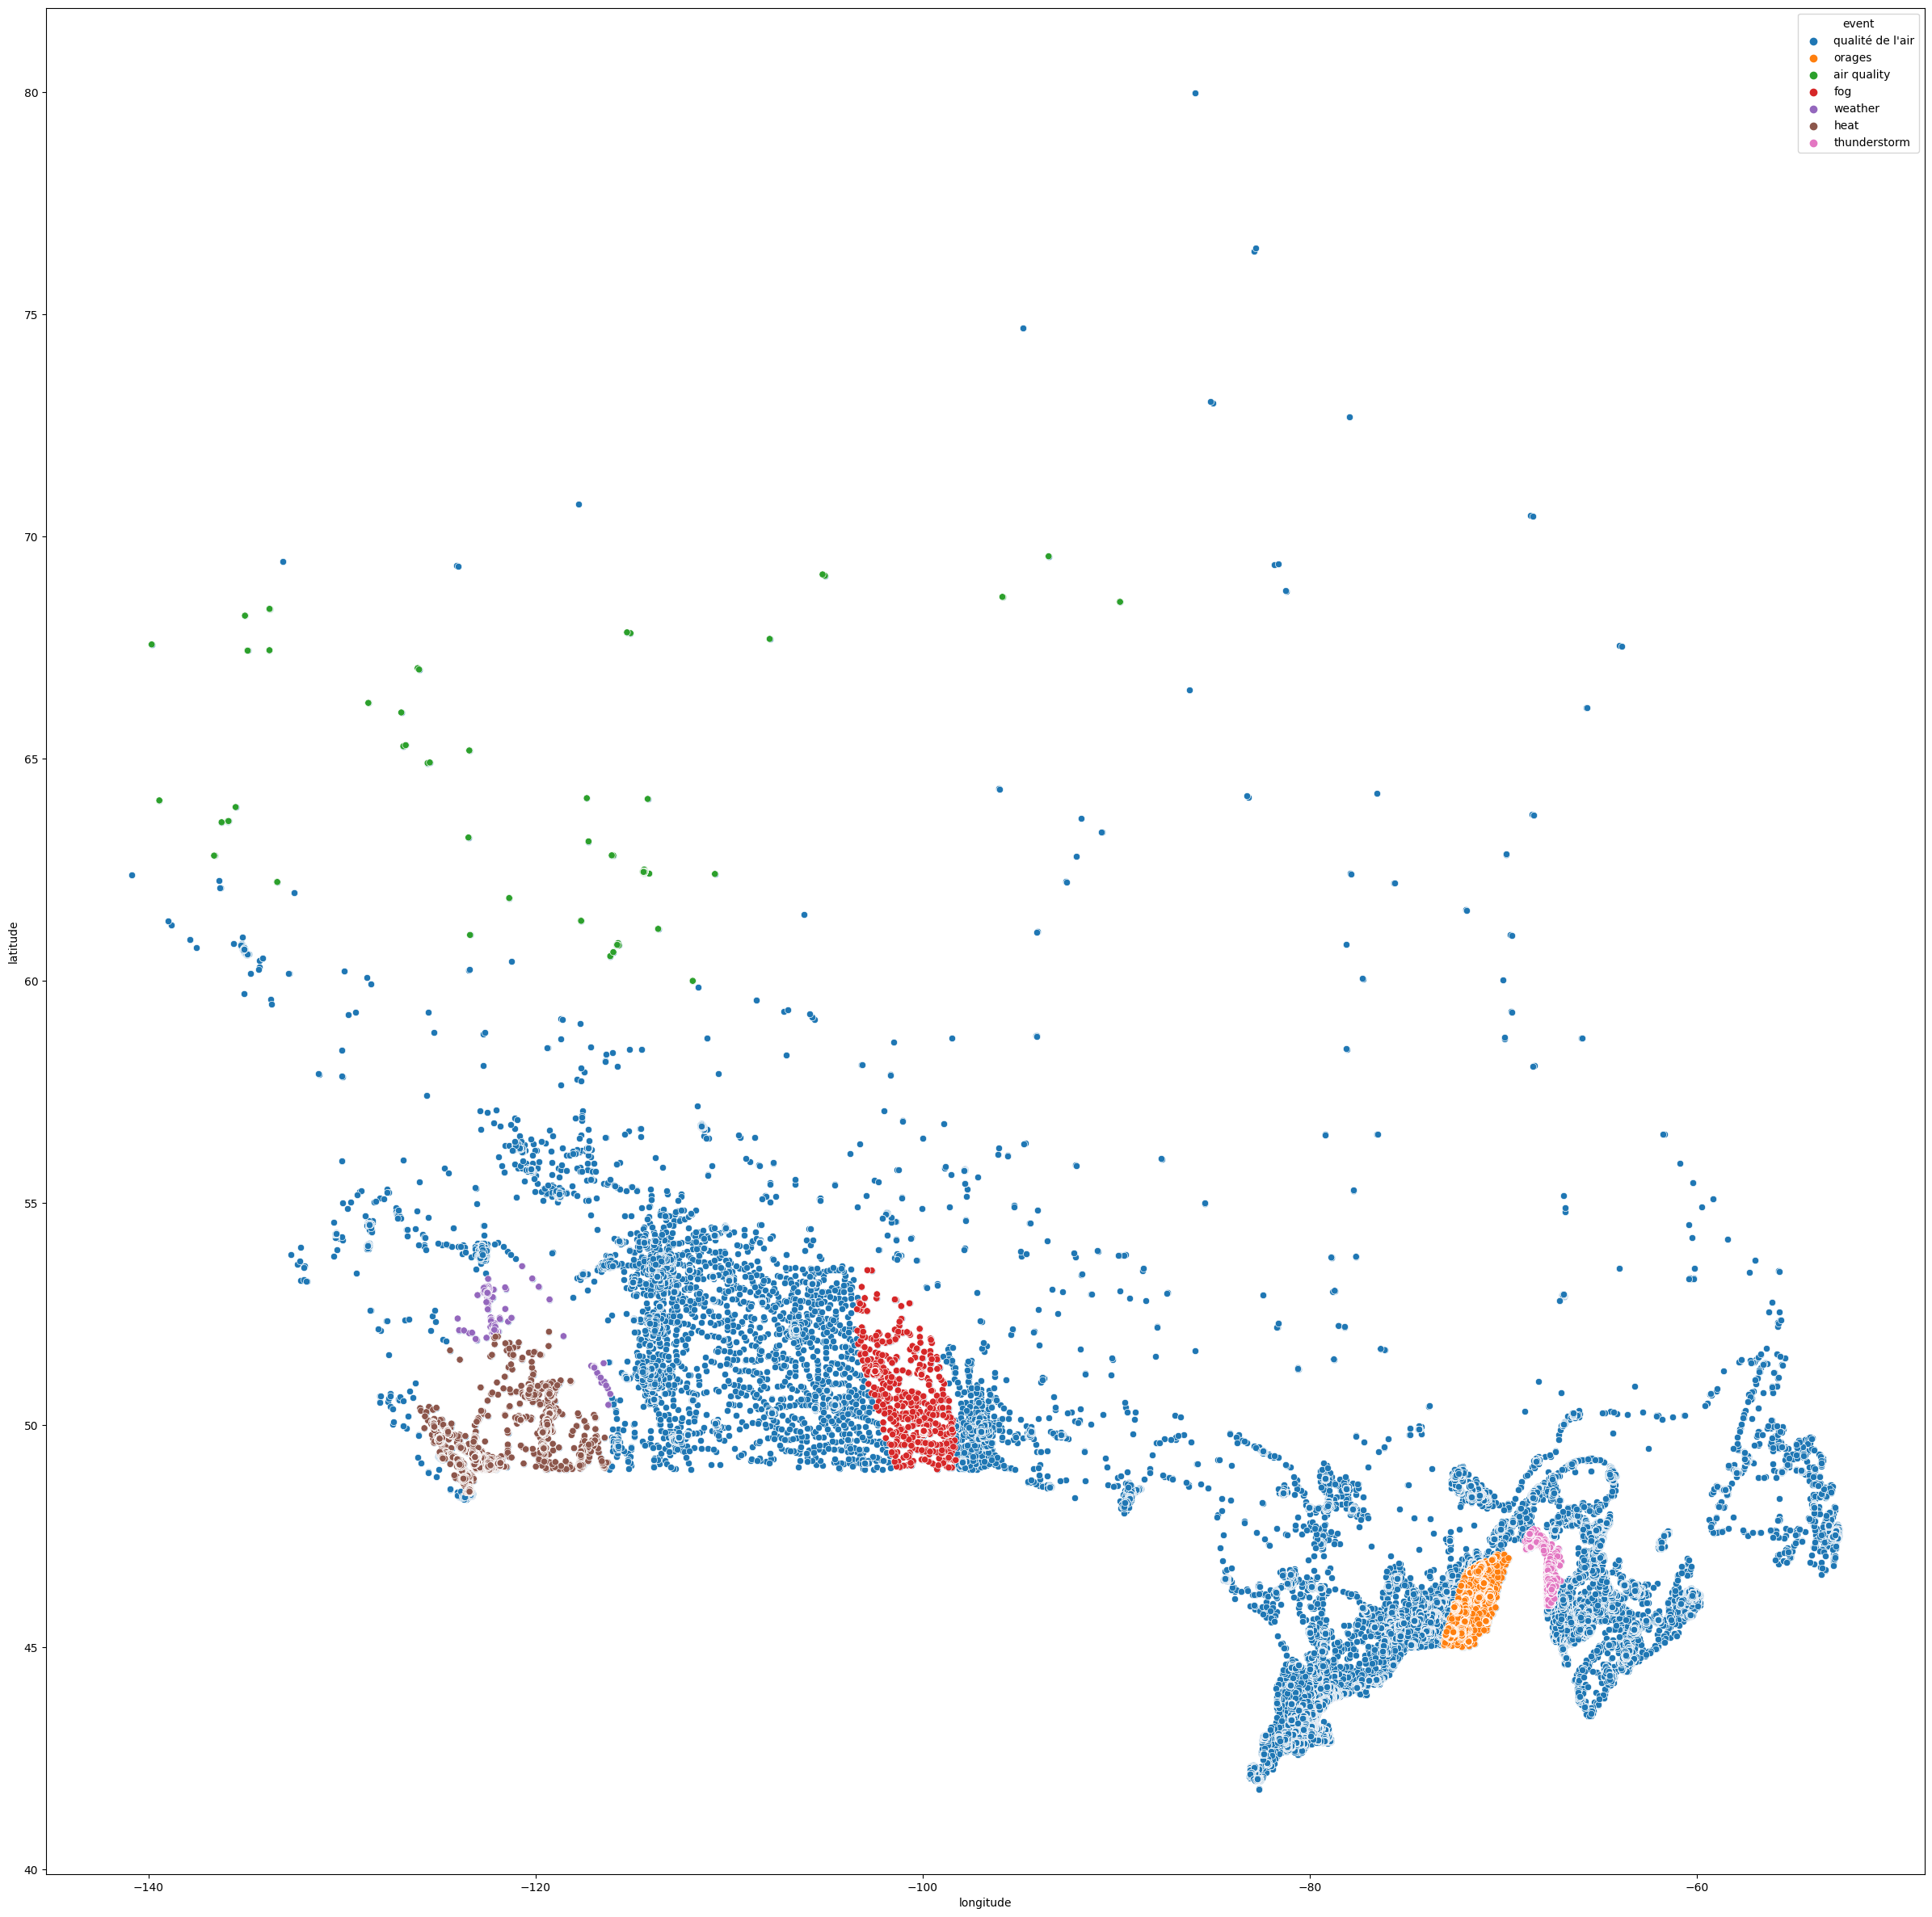

In [23]:
plt.figure(figsize=(30, 30))
sns.scatterplot ( data = cities, x='longitude',y='latitude')
sns.scatterplot ( data = city_event, x='longitude',y='latitude',hue='event')
plt.show()

In [24]:
city_event = city_event[['province', 'region','event']]

In [25]:
city_event['province'] = city_event['province'].astype('str')
city_event['region'] = city_event['region'].astype('str')
city_event['event'] = city_event['event'].astype('str')

In [26]:
city_event.drop_duplicates(inplace=True)

In [29]:
city_event['datetime'] = datetime.datetime.now()

### push data to Postgres database

####  Ingest the data into your own database in our PostgreSQL server<br>

In [30]:
db_secret = {
    'drivername' : 'postgresql+psycopg2',
    'host'       : 'mmai5100postgres.canadacentral.cloudapp.azure.com',
    'port'       :'5432',
    'username'   : 'sriku241',
    'password'   :'2023!Schulich',
    'database'   :'sriku241_db',
    
}

In [31]:
db_connection_url = sa.engine.URL.create(
    drivername = db_secret['drivername'],
    username   = db_secret['username'],
    password   = db_secret['password'],
    host       = db_secret['host'],
    port       = db_secret['port'],
    database   = db_secret['database']
)

In [32]:
engine = sa.create_engine(db_connection_url)

In [33]:
create_schema = text("CREATE SCHEMA IF NOT EXISTS p2_group_assignment") 
with engine.connect() as connection:
    connection.execute(create_schema)

In [34]:
city_event.info()

<class 'pandas.core.frame.DataFrame'>
Index: 69 entries, 0 to 174689
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   province  69 non-null     object        
 1   region    69 non-null     object        
 2   event     69 non-null     object        
 3   datetime  69 non-null     datetime64[ns]
dtypes: datetime64[ns](1), object(3)
memory usage: 2.7+ KB


In [35]:
city_event.to_sql(
    name='weather_alerts',
    schema = 'p2_group_assignment',
    con=engine,
    if_exists='replace',
    index=False,
    method='multi',
    dtype={
        'province': sa.types.VARCHAR(255),
        'Title': sa.types.VARCHAR(255),
        'region': sa.types.VARCHAR(255),
        'event': sa.types.VARCHAR(255),
        'datetime': sa.DateTime
    }
)

69

-----------------------------------------------------------------------------------------------------